In [15]:
# Example on how to dig into a .kwik file
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py

matplotlib.style.use('ggplot')


# Check wihic computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name
if  comp_name == 'chim':
    #sys.path.append('/Users/zeke/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join(os.path.abspath('W:') , "earneodo", "bci_zf")
elif  'lookfar' in comp_name:
    sys.path.append('/Users/zeke/repos/ephysflow')
    sys.path.append('/Users/zeke/repos/soundflow/sound_tools')
    experiment_folder = os.path.join(os.path.abspath('/Volumes') , 'gentner', 'earneodo', 'bci_zf')

if 'lintu' in comp_name:
    sys.path.append('/mnt/cube/earneodo/repos/soundflow/sound_tools')
    sys.path.append('/mnt/cube/earneodo/repos/ephysflow')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

raw_data_folder = os.path.join(experiment_folder, 'raw_data')
ss_data_folder = os.path.join(experiment_folder, 'ss_data')
export_data_folder = os.path.join(experiment_folder, 'export_data', 'tejaswy')


#file structure
bird_id = 'z003'
sess = 1
rec = 'a'
run = 1
sess_name = 'Pen04_Rgt_AP1500_ML0__Site01_Z1500__z003_cat_P04_S01_1_02'

raw_file_folder = os.path.join(raw_data_folder, bird_id, str(sess).zfill(3))
raw_file_name = rec + '_' + str(run).zfill(2) + '_song.wav'
raw_file_path = os.path.join(raw_file_folder, raw_file_name)
ss_file_folder = os.path.join(export_data_folder, bird_id, "S{:03d}_{}".format(sess, sess_name))
kwik_files = [f for f in os.listdir(ss_file_folder) if f.endswith('.kwik')]
kwik_file = kwik_files[0]

# open the file in read mode
kwik_file = h5py.File(os.path.join(ss_file_folder, kwik_file), 'r')   

Computer: lintu.ucsd.edu


In [16]:
# functions to browse through the stims and units
from phy_tools import kwik_functions as kwf

# List all the wave stimuli in the file
all_stim_names = kwf.list_sound_stimuli(kwik_file)
print "stimulus names"
print all_stim_names
print ""

# list all the sorted units
all_units = kwf.list_units(kwik_file)
# this returns a numpy recarray with cols:
# group: site group (electrode shank)
# clu: cluster number
# qlt: sorting quality: 1 is MUA, 2 is well isolated (by default, only these 2 qlt's are returned)
# For instance, see all the clusters that are either mua or good units.
print all_units['clu']

stimulus names
['sound_001_40000' 'sound_002_40000' 'sound_003_40000' 'sound_004_40000'
 'sound_005_40000' 'sound_006_40000' 'sound_007_40000' 'sound_008_40000']

[100 102 105 106 108  36  46  88  90  91  92  95  97  98]


In [18]:
print all_units[0]

(0, 100, 1)


Stamps of this event occurrences
[  567361  1229859  6121201  7285657  7822651  8050429  8954025 11074223
 12282745 18298707 19175661 22601477 23751789 25487457 26074955 26736191
 29829179 30323623 30623369 30852599 32592053 33371155 33547985 35967677
 36300759 37340213 38158709 41396773 43546453 46671637]

Sampling rate (Hz): 31250.0
Metadata
{'stim': {u'sampling_rate': 40000.0}, 'stream': {}}
{u'sampling_rate': 40000.0}


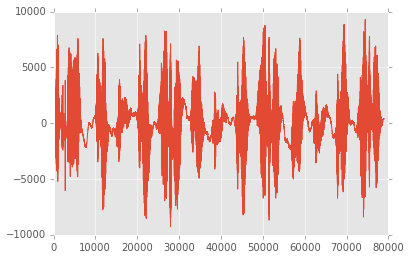

In [4]:
# get one of the stimuli:
from basic_viewing.events import Event, Sound
# creating a stimulus object with that name will refer to the data of it in the kwik file
stim = Sound('sound_005_40000', h5=kwik_file)

# some queries on the stimulus:
# stamps in the recording where the event started:
print "Stamps of this event occurrences"
print stim.start
# sampling frequency of the recording (i.e, of the recording)
print ""
print "Sampling rate (Hz): " + str(stim.sampling_rate)

# get the actual waveform of the stimulus as it was played and its metadata:
waveform, meta = stim.get_waveform()
# meta is a dictionary with metadata:
# sampling_rate: sampling rate of the waveform (independent from recording)
# synt: whether it is synthetic song or not
# type: birds own song (bos), (con)specific, (rev)ersed bos, etc..
print "Metadata"
print meta #note that there is metadata for the stimulus and for the stream
print meta['stim']
plt.plot(waveform)

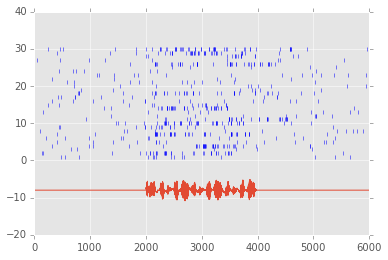

In [5]:
# get one of the units:
from basic_viewing.units import Unit

one_unit = all_units[2]
one_unit_clu = one_unit['clu']

# instance a Unit object
unit = Unit(one_unit_clu, h5=kwik_file)
# get the spike times (in sample units)
unit.get_time_stamps()
# get the sampling rate of the recording
s_f = unit.sampling_rate

#get a raster for this unit around a window of [-2, 4] sec after each stimulus onset
before_ms = 2000
after_ms = 4000
start_points = stim.start - np.int(s_f * before_ms/1000.) #start_points has to be in sample units

rs = unit.get_raster(start_points, before_ms + after_ms, span_is_ms=True, return_ms=True)
# the raster is an n_trial * m array (where m can be sample or ms).
# in each row, it contains the timestamps (in samples or ms) of spikes relative to the beginning of the trial

# plot the raster
from basic_viewing import basic_plot as bp
b = np.outer((np.arange(rs.shape[0]) + 1), np.ones(rs.shape[1]))
plt.scatter(rs, b, marker='|')
plt.xlim(0, before_ms + after_ms)

# plot the waveform underneath the raster
span_before = np.zeros(np.int(before_ms/1000. * meta['stim']['sampling_rate']))
span_before[:] = np.nan
span_after = np.zeros(np.int(after_ms/1000. * meta['stim']['sampling_rate']) - waveform.size)
waveform_plot = np.insert(waveform, 0, span_before)
waveform_plot = np.insert(span_after, 0, waveform_plot)
waveform_t_plot = np.arange(waveform_plot.size)*1000./meta['stim']['sampling_rate']
plt.plot(waveform_t_plot, (waveform_plot/32768.-0.8)*10)


In [6]:
from basic_viewing.basic_plot import plot_raster, sparse_raster
import scipy.signal as sg
from scipy.signal import spectrogram

def plot_waveform(x, before_ms, after_ms, s_f, ax=None):
    span_before = np.zeros(np.int(before_ms/1000. * s_f))
    span_before[:] = np.nan
    span_after = np.zeros(np.int(after_ms/1000. * s_f) - x.size)
    waveform_plot = np.insert(x, 0, span_before)
    waveform_plot = np.insert(span_after, 0, waveform_plot)
    waveform_t_plot = np.arange(waveform_plot.size)*1000./s_f
    if ax is None:
        raster_fig = plt.figure()
        ax = raster_fig.add_axes([0, 0, 1, 1])
    ax.plot(waveform_plot)
    ax.set_xlim(0, waveform_plot.size)
    ax.plot((span_before.size, span_before.size), (np.min(waveform_plot), np.max(waveform_plot)), 'k--')
    return ax

def pad_input(sliding_func):
    def out_padded(*args, **kwargs):
        n_window = kwargs['nperseg']
        n_overlap = kwargs['noverlap']
        
        # pad the window so the output is the same size as the input
        assert(n_window%2 == 0)
        before_padding = n_window/2
        after_padding = n_window/2 -1 
        x = np.pad(args[0], (before_padding, after_padding), 'constant', constant_values = (0,0))
        # make the new input to the function
        args = (x,) + args[1:]
        return sliding_func(*args, **kwargs)
    
    return out_padded


#decorate spectrogram to pad so output and input sizes match
spectrogram = pad_input(spectrogram)
def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 1024, n_overlap = None, sigma=None, ax=None, **kwargs):
    
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 7./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), scaling='spectrum')
    
    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0*n_overlap/s_f)*1000.), f, np.log(Sxx))
    ax.set_xlim(-before_ms, after_ms)
    ax.set_ylim(0,7000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax
    
#spectr, ax3 = plot_spectrogram(waveform, before_ms, after_ms, meta['stim']['sampling_rate'], n_window = 1024, n_overlap=512, scaling='spectrum')
# plot the raster, the stimulus sonogram and the auxiliaries
before_ms = 100
after_ms = 2300

# The raster:
start_points = stim.start - np.int(s_f * before_ms/1000.) #start_points has to be in sample units
rs = unit.get_raster(start_points, before_ms + after_ms, span_is_ms=True, return_ms=True)


width=2
#ax1 = fig.add_axes([0,.5,2,0.25])
#rast, ax1 = plot_raster(sparse_raster(rs), t0=before_ms, ax=ax1)
#rast, ax1 = plot_raster(sparse_raster(rs), t0=before_ms, bin_size=15, ax=ax1)
ax1 = fig.add_axes([0,0.5,width,0.1])
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
ax1 = plot_waveform(waveform, before_ms, after_ms, meta['stim']['sampling_rate'], ax=ax1)

ax0 = fig.add_axes([0,0,width,0.5])
spectr, ax0 = plot_spectrogram(waveform, before_ms, after_ms, meta['stim']['sampling_rate'], ax=ax0,
                               n_window = 1024, n_overlap=128, scaling='spectrum')
ax0 = fig.add_axes([0,0,width,0.5])
ax0.yaxis.set_ticks([5000])

#synthetic
synth, meta_synth = stim.get_waveform(stream='synthesized')
ax2 = fig.add_axes([0,.6,width,0.5])
spectr, ax2 = plot_spectrogram(synth, before_ms, after_ms, meta['stim']['sampling_rate'], ax=ax2,
                               n_window = 1024, n_overlap=128, scaling='spectrum')
ax2.xaxis.set_ticks([])
ax2.yaxis.set_ticks([5000])

w_axes = []
for i, stream in enumerate(['alpha', 'beta']):
    w_form, w_meta = stim.get_waveform(stream=stream)
    w_axes.append(fig.add_axes([0, 1.1 + i*0.2, width, 0.2]))
    this_ax = w_axes[i]
    this_ax = plot_waveform(w_form, before_ms, after_ms, meta['stim']['sampling_rate'], ax=this_ax)
    this_ax.xaxis.set_ticks([])
    this_ax.yaxis.set_ticks([])

# plot all the rasters
rs_axes = []
for i_c, a_clu in enumerate(all_units['clu']):
    rs_axes.append(fig.add_axes([0, 1.5 + i_c*0.15, width, 0.2]))
    this_ax = rs_axes[i_c]
    
    unit = Unit(a_clu, h5=kwik_file)
    unit.get_time_stamps()
    rs = unit.get_raster(start_points, before_ms + after_ms, span_is_ms=True, return_ms=True)
    rast, this_ax = plot_raster(sparse_raster(rs), t0=before_ms, ax=this_ax)
    
    this_ax.xaxis.set_ticks([])
    this_ax.yaxis.set_ticks([])

fig.set_tight_layout(True)
fig.set_size_inches(2, (1.5+all_units.shape[0]*0.2))
fig.show()

fig.savefig(os.path.join(ss_file_folder, '{}_rasters.eps'.format(stim.name)), orientation='portrait', format='eps')
fig.savefig(os.path.join(ss_file_folder, '{}_rasters.png'.format(stim.name)))

NameError: name 'fig' is not defined

In [7]:
# go through all the units and plot the rasters
# instance a Unit object
all_units['clu']
unit = Unit(one_unit_clu, h5=kwik_file)
# get the spike times (in sample units)
unit.get_time_stamps()
# get the sampling rate of the recording
s_f = unit.sampling_rate

In [8]:
fig.savefig(os.path.join(ss_file_folder, '{}_rasters.png'.format(stim.name)))#rs.shape[1]

NameError: name 'fig' is not defined

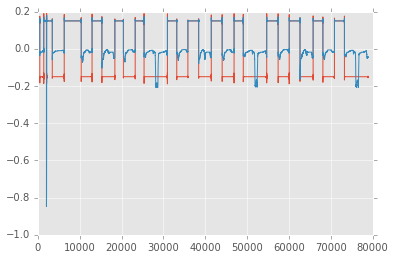

In [9]:
# Get one of the arrays (for instance, parameters alpha and beta)
alpha, meta = stim.get_waveform(stream='alpha')
beta, meta = stim.get_waveform(stream='beta')
plt.plot(alpha)
plt.plot(beta)

In [10]:
# Get the syllables' segments for that stimulus:
[syllables_array, syllables_meta] = stim.get_syllables()
# This returns an array, and a dictionary (empty so far) with the metadata
# The table has three columns: Syllable identifiers (note that the syllables repeat across the realization), start, end
# (stamps are in sample units, with the same sampling rate as everything in the group for this stimulus)
print syllables_array

[[    0   467  1419]
 [    1  3450  6304]
 [    2 10356 12954]
 [    3 15307 18406]
 [    2 20433 23264]
 [    4 25379 30962]
 [    2 33196 35854]
 [    3 38429 41441]
 [    2 44042 46889]
 [    4 49087 54689]
 [    2 57414 60063]
 [    3 62645 65780]
 [    2 68113 70877]
 [    4 73259 78897]]


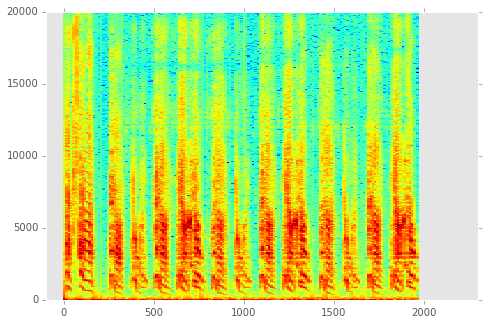

In [11]:
import scipy.signal as sg

def pad_input(sliding_func):
    def out_padded(*args, **kwargs):
        n_window = kwargs['nperseg']
        n_overlap = kwargs['noverlap']
        
        # pad the window so the output is the same size as the input
        assert(n_window%2 == 0)
        before_padding = n_window/2
        after_padding = n_window/2 -1 
        x = np.pad(args[0], (before_padding, after_padding), 'constant', constant_values = (0,0))
        # make the new input to the function
        args = (x,) + args[1:]
        return sliding_func(*args, **kwargs)
    
    return out_padded

from scipy.signal import spectrogram

spectrogram = pad_input(spectrogram)

def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 1024, n_overlap = None, sigma=None, ax=None, **kwargs):
    
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 7./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), scaling='spectrum')
    
    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh((t*1000. - n_window/(2.*s_f)*1000.), f, np.log(Sxx))
    ax.set_xlim(-before_ms, after_ms)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax
    
spectr, ax3 = plot_spectrogram(waveform, before_ms, after_ms, meta['stim']['sampling_rate'], n_window = 1024, n_overlap=512, scaling='spectrum')

In [12]:
f, t, Sxx = spectrogram(waveform, meta['stim']['sampling_rate'], nperseg = 1024, noverlap=128, scaling='spectrum')

In [13]:
t-512./40000.

array([ 0.    ,  0.0224,  0.0448,  0.0672,  0.0896,  0.112 ,  0.1344,
        0.1568,  0.1792,  0.2016,  0.224 ,  0.2464,  0.2688,  0.2912,
        0.3136,  0.336 ,  0.3584,  0.3808,  0.4032,  0.4256,  0.448 ,
        0.4704,  0.4928,  0.5152,  0.5376,  0.56  ,  0.5824,  0.6048,
        0.6272,  0.6496,  0.672 ,  0.6944,  0.7168,  0.7392,  0.7616,
        0.784 ,  0.8064,  0.8288,  0.8512,  0.8736,  0.896 ,  0.9184,
        0.9408,  0.9632,  0.9856,  1.008 ,  1.0304,  1.0528,  1.0752,
        1.0976,  1.12  ,  1.1424,  1.1648,  1.1872,  1.2096,  1.232 ,
        1.2544,  1.2768,  1.2992,  1.3216,  1.344 ,  1.3664,  1.3888,
        1.4112,  1.4336,  1.456 ,  1.4784,  1.5008,  1.5232,  1.5456,
        1.568 ,  1.5904,  1.6128,  1.6352,  1.6576,  1.68  ,  1.7024,
        1.7248,  1.7472,  1.7696,  1.792 ,  1.8144,  1.8368,  1.8592,
        1.8816,  1.904 ,  1.9264,  1.9488,  1.9712])

In [14]:
# variables and parameters
y = window.data[0,:]
fs = window.sound.s_f
t = np.arange(0,y.shape[0], dtype=np.float)/fs

n_window = 1024
n_overlap = n_window-1
sigma = 7./1000.*fs

# pad the window so the output is the same size as the input
assert(n_window%2 == 0)
before_padding = n_window/2
after_padding = n_window/2 -1 
x = np.pad(y, (before_padding, after_padding), 'constant', constant_values = (0,0))

# Get the spectrogram of the padded segment
# overlap is n_window - 1, so that it slides across each time point
# window is gaussian so it ends up doing a sliding gabor transform, which is what I need to compute the fundamental
f, t, Sxx = sg.spectrogram(x, fs, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), scaling='spectrum')

ax1 = plt.subplot(311)
plt.plot(t, y)
plt.subplot(212, sharex=ax1)
plt.pcolormesh(t, f, np.log(Sxx))
plt.ylim(0, 7000)

plt.show()


NameError: name 'window' is not defined